# **Laboratorio 4 - Informe**
### Grupo 4:
     - S. Calvo C.I 5.711.417-7     
     - X. Iribarnegaray C.I 5.253.705-9
     - J. Simonelli C.I 5.405.358-4

## **1. Inicializaciones**

#### **1.1 Bibliotecas**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from collections import defaultdict
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from IPython.display import display, HTML # pip install jinja2 , necesario para mostrar tablas con styles

#### **1.2 Preprocesamiento**

En el siguiente bloque dividimos el dataset en conjuntos de train y test (80/20), y el conjunto de train lo dividimos en conjunto de entrenamienton y validación (90/10). Además, removemos los features *pidnum* y *time*, esta última por consigna.

In [2]:
data = pd.read_csv('dataset.csv')

def init(data):
    data = data.drop(columns=['pidnum','time'])
    train, test = train_test_split(data, test_size=0.2, random_state=0)
    train_90, val = train_test_split(train, test_size=0.1, random_state=0)
    return train, train_90, val, test

target = 'cid'

train, train_90, val, test = init(data)


In [3]:
X_final_train, y_final_train = train.drop(columns=[target]), train[target]
X_train, y_train = train_90.drop(columns=[target]), train_90[target]
X_val, y_val = val.drop(columns=[target]), val[target]
X_test, y_test = test.drop(columns=[target]), test[target]

En el dataset original, múltiples atributos se encuentran en diferentes escalas. Por ejemplo, el atributo *age* se encuentra en un rango de 0 a 100, mientras que el atributo *chol* se encuentra en un rango de 100 a 400, o el atributo *cd820* que llega a tomar valores por encima de 1000. Esto puede provocar que la red le atribuya "mayor importancia" a ciertos atributos de mayor valor, lo que no representa la realidad. Por esto, es necesario estandarizar los atributos continuos, o sea, transformar los valores de entrada con tal de obtener una varianza de 1 y media de 0. Para ello, utilizamos la clase StandardScaler de la librería scikit-learn sobre todos los atributos continuos `continuous_features`. Además, es necesario aplicar One-hot Encoding sobre todo atributo categórico de más de dos valores, que en este caso es solamente *trt*, para que la red pueda interpretarlos correctamente.

In [4]:
discrete_features = ['trt']
continuous_features = [
    'age', 
    'wtkg', 
    'preanti', 
    'cd40', 
    'cd420', 
    'cd80', 
    'cd820',
    'karnof'
]

#Create a ColumnTransformer with OneHotEncoder for discrete and StandardScaler for continuous features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), discrete_features)
    ],
    remainder='passthrough'  # Keep other columns as they are (if any)
)

#Fit the preprocessor on the training set and apply to other sets
#Using fit_transform on X_train and transform on others to avoid data leakage
X_train = pd.DataFrame(preprocessor.fit_transform(X_train), columns=preprocessor.get_feature_names_out(), index=X_train.index)
X_val = pd.DataFrame(preprocessor.transform(X_val), columns=preprocessor.get_feature_names_out(), index=X_val.index)
X_final_train = pd.DataFrame(preprocessor.transform(X_final_train), columns=preprocessor.get_feature_names_out(), index=X_final_train.index)
X_test = pd.DataFrame(preprocessor.transform(X_test), columns=preprocessor.get_feature_names_out(), index=X_test.index)

#Set input size for models that need it
input_size = X_train.shape[1]



## **2. Modelos**

### **Modelo 1**

La implementación de un modelo de regresión logística en este caso utiliza la biblioteca scikit-learn para construir un clasificador base a partir de los datos de entrenamiento.

Comenzamos instanciando el modelo con `LogisticRegression()` y entrenándolo en el conjunto de entrenamiento mediante `fit`. Luego, el modelo genera predicciones en el conjunto de validación con el método `predict`. Para evaluar su rendimiento, se calcula la precisión (accuracy), que mide el porcentaje de predicciones correctas.

In [5]:
def train_logistic_regression(X_train, y_train, X_val, y_val):
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    
    return model, accuracy

model1, accuracy_val = train_logistic_regression(X_train, y_train, X_val, y_val)

print(f"Accuracy del Modelo 1 en el conjunto de validación: {accuracy_val:.4f}")


Accuracy del Modelo 1 en el conjunto de validación: 0.8198


Previo a detallar la implementación de las redes neuronales solicitadas, implementaremos la función de entrenamiento que utilizaremos en todos los modelos restantes del informe. Esta función recibe como parámetros el modelo, el conjunto de entrenamiento, el conjunto de validación, la cantidad de épocas, la tasa de aprendizaje `lr`, el optimizador, y el número del modelo. La función entrena el modelo y devuelve el acierto y pérdida por época para el conjunto de entrenamiento y validación.

In [6]:
def train_model(model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, epochs=100, lr=0.01, criterion='CrossEntropyLoss', modelNumber=2):
    # Loss function
    if (criterion == 'CrossEntropyLoss'):
        loss_fn = torch.nn.CrossEntropyLoss()
    elif (criterion == 'BCELoss'): 
        loss_fn = torch.nn.BCELoss()
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_loss, val_loss = [], []
    train_accuracy, val_accuracy = [], []
    
    for epoch in range(epochs):
        model.train()

        # Forward pass
        y_train_pred = model(X_train_tensor)
        loss = loss_fn(y_train_pred, y_train_tensor)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Training metrics
        if (modelNumber == 2):
            predicted = torch.argmax(y_train_pred, dim=1)
        else:
            predicted = y_train_pred.round()
            
        train_acc = (predicted == y_train_tensor).float().mean().item()
        
        train_loss.append(loss.item())
        train_accuracy.append(train_acc)
        
        # Validation metrics
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            if (modelNumber == 2):
                val_predicted = torch.argmax(val_outputs, dim=1)
            else:
                val_predicted = (val_outputs).round()
            val_acc = (val_predicted == y_val_tensor).float().mean().item()
        
        # Store metrics
        val_loss.append(loss_fn(val_outputs, y_val_tensor).item())
        val_accuracy.append(val_acc)
    
    return train_loss, val_loss, train_accuracy, val_accuracy

epochs = 100
learning_rate = 0.01


La función inicia definiendo la función de pérdida en función del tipo de criterio especificado. Si el criterio es *CrossEntropyLoss*, se utiliza para tareas de clasificación multiclase, mientras que *BCELoss* se emplea para clasificación binaria.

Luego, se establece el optimizador, en este caso Adam, con la tasa de aprendizaje especificada. A continuación, la función entra en un bucle de entrenamiento que itera durante el número de épocas indicadas. En cada época, el modelo pasa a modo de entrenamiento mediante `model.train()`, lo cual habilita la función de Dropout, que será usada en las arquitecturas propuestas para el Modelo 5. Se realiza una pasada hacia adelante sobre los datos de entrenamiento `X_train_tensor`, obteniendo las predicciones `y_train_pred` del modelo. La pérdida se calcula comparando las predicciones con las etiquetas verdaderas en `y_train_tensor` usando la función de pérdida previamente definida.

Para actualizar los parámetros, primero reiniciamos los gradientes mediante `optimizer.zero_grad()`, luego se realiza la pasada hacia atrás utilizando `loss.backward()`, y finalmente se actualizan los parámetros del modelo mediante `optimizer.step()`. La precisión de entrenamiento se calcula de acuerdo al criterio de pérdida: en el caso de *BCELoss*, se redondean las predicciones para obtener valores binarios (0 o 1); en el caso de *CrossEntropyLoss*, se utiliza `argmax` para seleccionar la clase con la probabilidad más alta. Estas predicciones se comparan con las etiquetas verdaderas para obtener la precisión, que junto a la pérdida de entrenamiento, se almacena para la época actual.

Posteriormente, el modelo se pone en modo de evaluación con `model.eval()` y se calculan las métricas de validación sin realizar ajustes en los parámetros. Las predicciones sobre el conjunto de validación `X_val_tensor` se procesan de manera similar a lo descrito anteriormente, y la precisión de validación se calcula y almacena junto con la pérdida en el conjunto de validación. 

Finalmente, la función retorna las pérdidas y precisiones de entrenamiento y validación para cada época, lo que permite observar la evolución del rendimiento del modelo a lo largo del entrenamiento.

Con respecto a los gráficos, implementamos la función `plot_metrics` para que, a partir de los resultados obtenidos en el entrenamiento y validación, se grafiquen las pérdidas y precisiones en función de las épocas.

In [7]:
epochs_list = range(0, epochs)

def plot_metrics(train_loss, val_loss, train_accuracy, val_accuracy):
    plt.figure(figsize=(12, 5))
    
    # Gráfico de pérdida
    plt.subplot(1, 2, 1)
    plt.plot(epochs_list, train_loss, label='Train Loss')
    plt.plot(epochs_list, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Gráfico de accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_list, train_accuracy, label='Train Accuracy')
    plt.plot(epochs_list, val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


### **Modelo 2**

El segundo modelo a implementar es ahora una red neuronal, de una sola neurona lineal, con dos salidas.

In [8]:
class SimpleLinearNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleLinearNN, self).__init__()
        self.linear = nn.Linear(input_size, 2)

    def forward(self, x):
        return self.linear(x)
    
    def predict(self, x):
        self.eval()
        
        with torch.no_grad():
            logits = self.forward(x)
            _, predicted_classes = torch.max(logits, 1)
        
        return predicted_classes


Para esta red, contamos con una capa lineal que toma un número de atributos de entrada (input_size) y produce dos salidas, que corresponden a los valores de activación de cada clase.

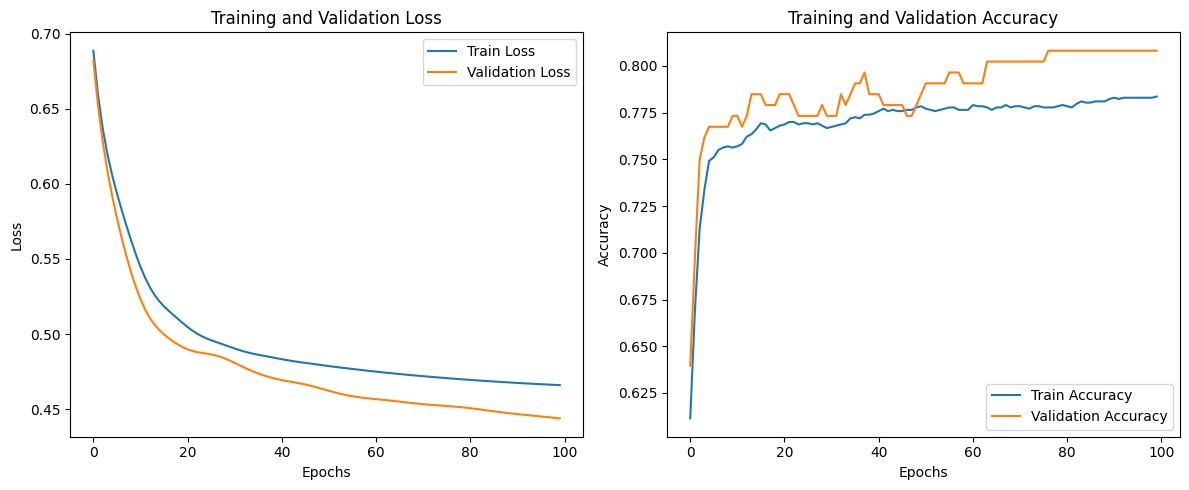

In [9]:
model2 = SimpleLinearNN(input_size)

X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.LongTensor(y_train.values)
X_val_tensor = torch.FloatTensor(X_val.values)
y_val_tensor = torch.LongTensor(y_val.values)

train_loss, val_loss, train_accuracy, val_accuracy = train_model(
    model2,
    X_train_tensor,
    y_train_tensor,
    X_val_tensor,
    y_val_tensor,
    epochs,
    learning_rate,
    criterion='CrossEntropyLoss',
    modelNumber=2
)

plot_metrics(train_loss, val_loss, train_accuracy, val_accuracy)

Modelo 3

In [10]:
class SigmoidNN(nn.Module):
    def __init__(self, input_size):
        super(SigmoidNN, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))
    
    def predict(self, x):
        self.eval()
        with torch.no_grad():
            probabilities = self.forward(x)
            predictions = probabilities.round()
        return predictions


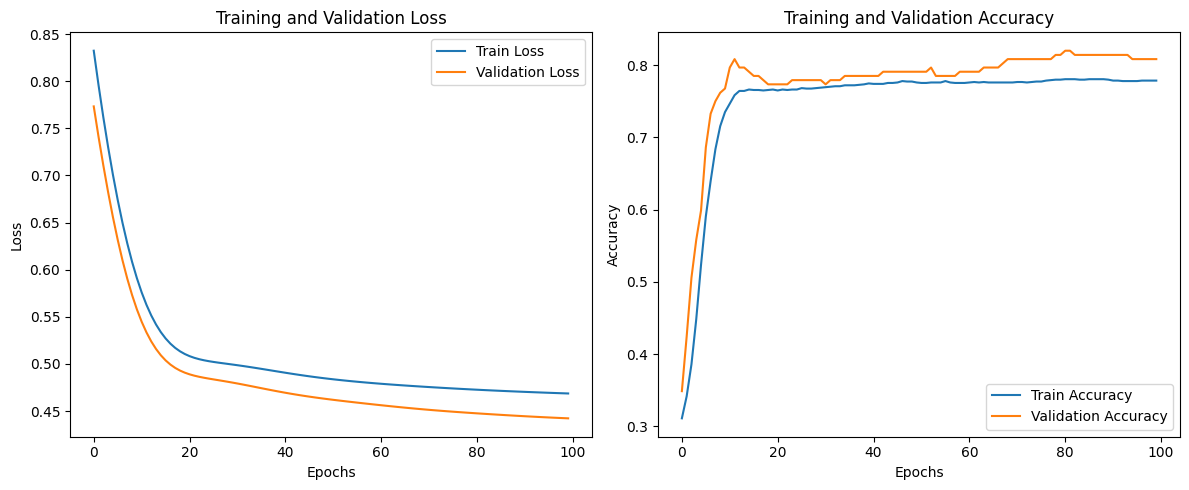

In [11]:
model3 = SigmoidNN(input_size)
X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.FloatTensor(y_train.values).unsqueeze(1) # explicar
X_val_tensor = torch.FloatTensor(X_val.values)
y_val_tensor = torch.FloatTensor(y_val.values).unsqueeze(1)

train_loss, val_loss, train_accuracy, val_accuracy = train_model(
    model3,
    X_train_tensor,
    y_train_tensor,
    X_val_tensor,
    y_val_tensor,
    epochs,
    learning_rate,
    criterion='BCELoss',
    modelNumber=3
)

plot_metrics(train_loss, val_loss, train_accuracy, val_accuracy)

Modelo 4

In [12]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_size):
        super(FeedForwardNN, self).__init__()
        self.hidden = nn.Linear(input_size, 16)
        self.output = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.sigmoid(self.hidden(x))
        return torch.sigmoid(self.output(x))
    
    def predict(self, x):
        self.eval()
        with torch.no_grad():
            probabilities = self.forward(x)
            predictions = probabilities.round()
        return predictions
    

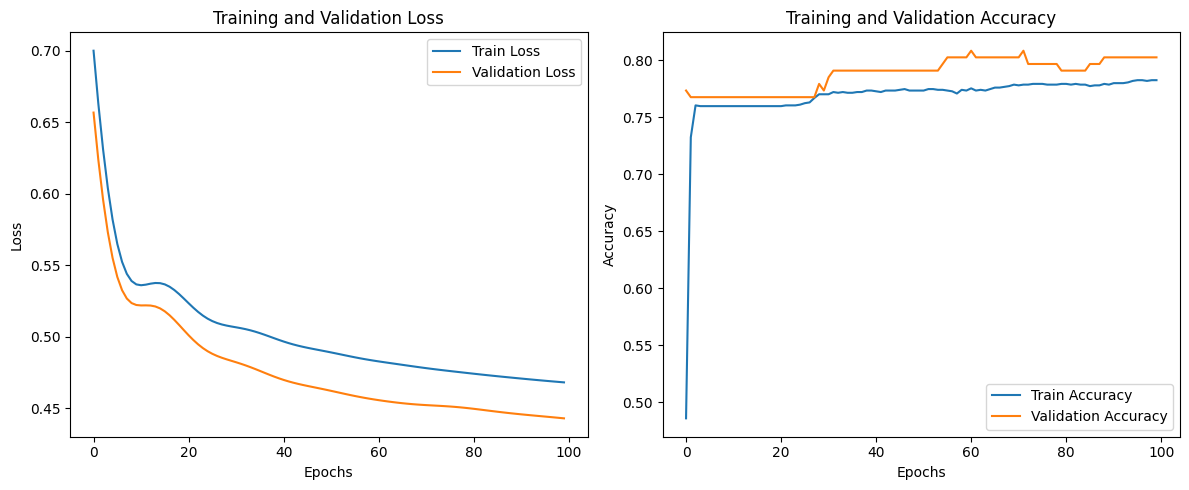

In [13]:
model4 = FeedForwardNN(input_size)
train_loss, val_loss, train_accuracy, val_accuracy = train_model(
    model4,
    X_train_tensor,
    y_train_tensor,
    X_val_tensor,
    y_val_tensor,
    epochs,
    learning_rate,
    criterion='BCELoss',
    modelNumber=4
)

plot_metrics(train_loss, val_loss, train_accuracy, val_accuracy)

Modelo 5

In [14]:
class ModelA(nn.Module):
    def __init__(self, input_size):
        super(ModelA, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.output = nn.Linear(32, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return torch.sigmoid(self.output(x))
    
    def predict(self, x):
        self.eval()
        with torch.no_grad():
            probabilities = self.forward(x)
            predictions = probabilities.round()
        return predictions

class ModelB(nn.Module):
    def __init__(self, input_size):
        super(ModelB, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.dropout = nn.Dropout(0.2)
        self.output = nn.Linear(16, 1)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        return torch.sigmoid(self.output(x))
    
    def predict(self, x):
        self.eval()
        with torch.no_grad():
            probabilities = self.forward(x)
            predictions = probabilities.round()
        return predictions

class ModelC(nn.Module):
    def __init__(self, input_size):
        super(ModelC, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 8)
        self.output = nn.Linear(8, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = torch.nn.functional.leaky_relu(self.fc1(x), negative_slope=0.01)
        x = self.dropout(x)
        x = torch.nn.functional.leaky_relu(self.fc2(x), negative_slope=0.01)
        x = self.dropout(x)
        x = torch.nn.functional.leaky_relu(self.fc3(x), negative_slope=0.01)
        return torch.sigmoid(self.output(x))
    
    def predict(self, x):
        self.eval()
        with torch.no_grad():
            probabilities = self.forward(x)
            predictions = probabilities.round()
        return predictions


In [15]:
models = {
    "ModelA": None,
    "ModelB": None,
    "ModelC": None
}

learning_rates = [0.01, 0.001, 0.0001]
results = {}

# Initializing 
win_counts = defaultdict(int)
num_experiments = 100

# Ejecutar el entrenamiento 100 veces
for experiment in range(num_experiments):
    best_model_name = None
    best_f1_score = 0

    # Entrenar y evaluar cada modelo con diferentes tasas de aprendizaje
    for model_name in models.keys():
        for lr in learning_rates:
            # Instanciar el modelo correspondiente
            if model_name == "ModelA":
                model = ModelA(input_size)
            elif model_name == "ModelB":
                model = ModelB(input_size)
            elif model_name == "ModelC":
                model = ModelC(input_size)
            
            # Entrenar el modelo
            train_loss, val_loss, train_accuracy, val_accuracy = train_model(
                model, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, 
                lr=lr, epochs=epochs, criterion='BCELoss' ,modelNumber=5
            )
            
            # Calcular el F1 score en el conjunto de validación
            f1 = f1_score(y_val_tensor, model.predict(X_val_tensor), average='weighted')
            
            # Guardar el mejor resultado en `results`
            if (model_name, lr) not in results or f1 > results[(model_name, lr)]["f1_score"]:
                results[(model_name, lr)] = {
                    "train_loss": train_loss,
                    "val_loss": val_loss,
                    "train_accuracy": train_accuracy,
                    "val_accuracy": val_accuracy,
                    "f1_score": f1,
                    "experiment": experiment
                }
            
            # Almacenar el mejor modelo de esta iteración
            if f1 > best_f1_score:
                best_f1_score = f1
                best_model_name = model_name
    
    # Incrementar el contador de victorias para el mejor modelo
    if best_model_name is not None:
        win_counts[best_model_name] += 1

# Calcular el porcentaje de victorias
win_percentages = {model_name: (win_counts[model_name] / num_experiments) * 100 for model_name in models.keys()}

# Mostrar los resultados
print("Porcentaje de veces que cada modelo salió como el mejor:")
for model_name, percentage in win_percentages.items():
    print(f"{model_name}: {percentage:.2f}%")


Porcentaje de veces que cada modelo salió como el mejor:
ModelA: 48.00%
ModelB: 20.00%
ModelC: 32.00%


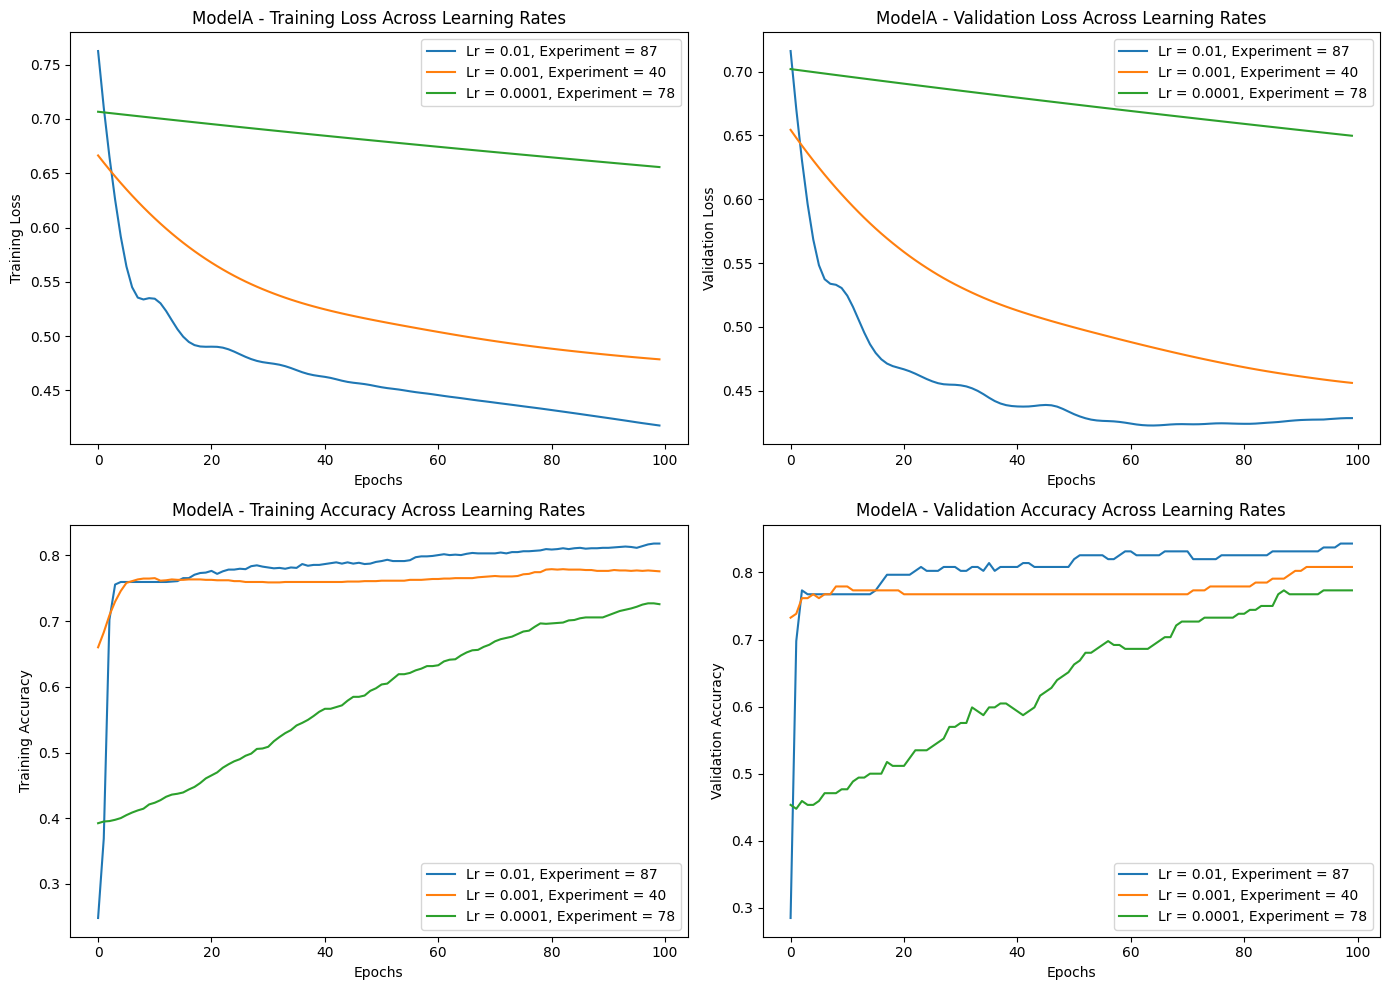

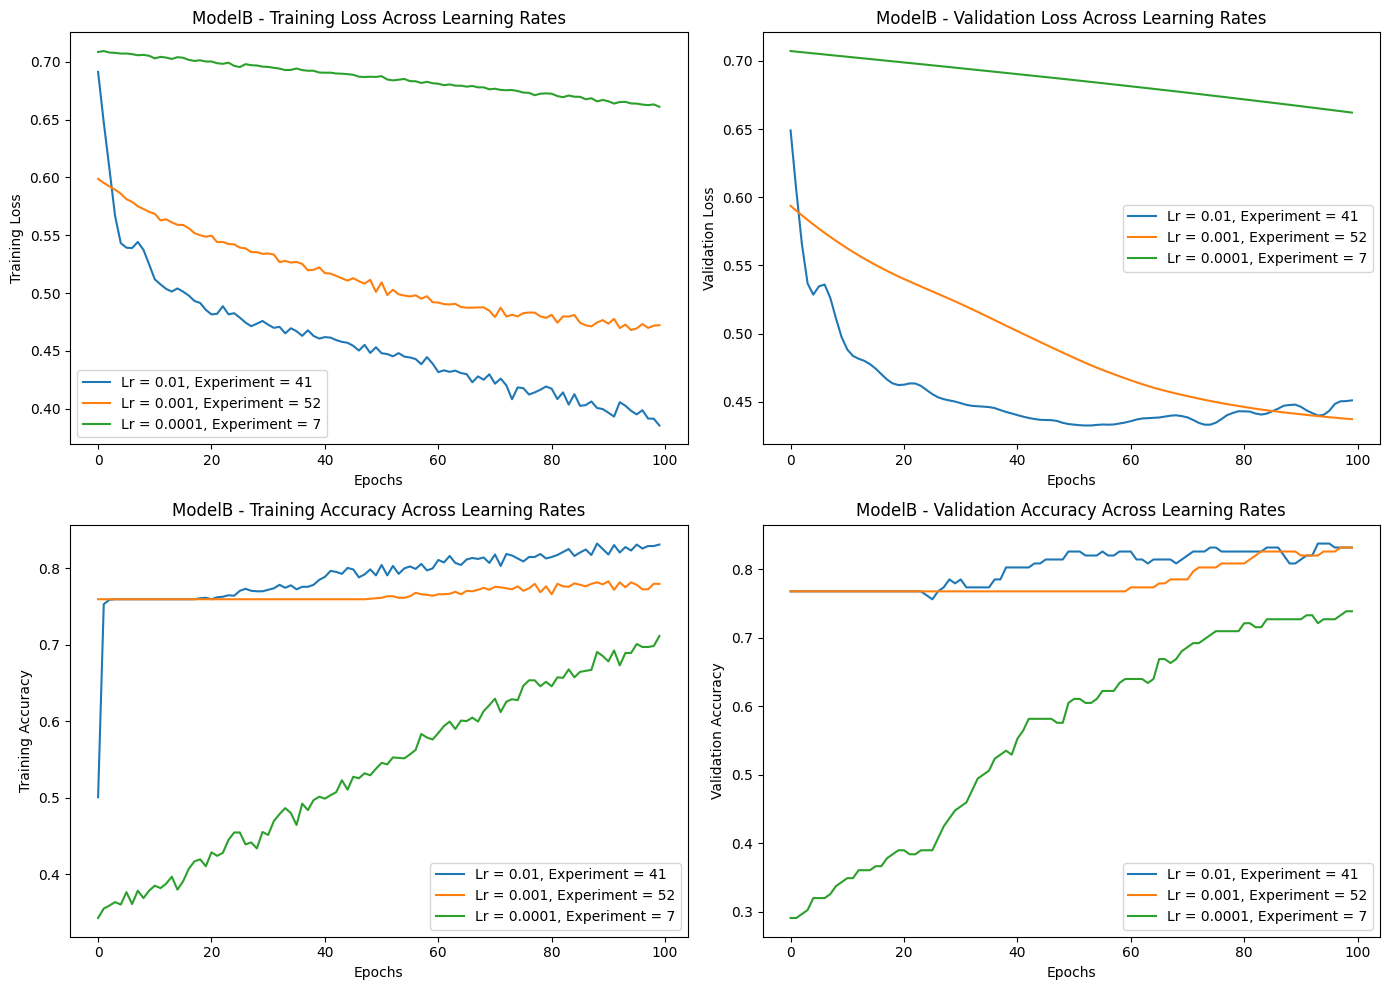

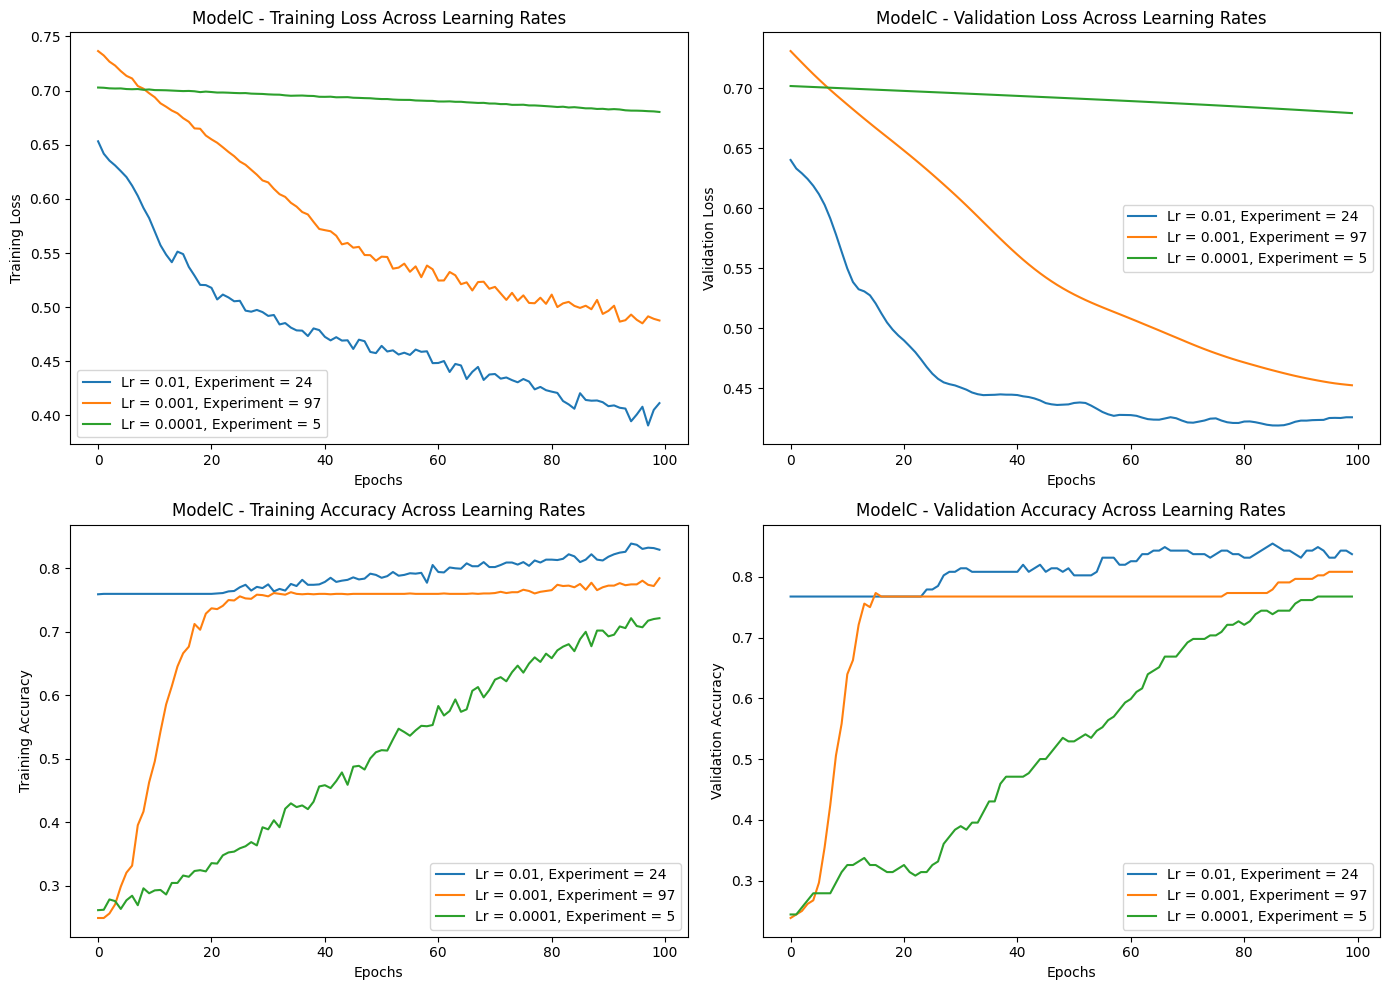

In [16]:
def plot_model_metrics_across_learning_rates(results):
    # Extract unique model names
    model_names = ['ModelA', 'ModelB', 'ModelC']
    
    # Plot for each model
    for model_name in model_names:
        # Initialize lists to hold data for each learning rate
        epochs_list = None
        all_train_loss, all_val_loss = {}, {}
        all_train_accuracy, all_val_accuracy = {}, {}
        
        # Collect data for all learning rates for the current model
        for (name, lr), metrics in results.items():
            if name == model_name:
                # Initialize epoch list only once
                if epochs_list is None:
                    epochs_list = range(0, len(metrics["train_loss"]))
                
                all_train_loss[lr] = metrics["train_loss"]
                all_val_loss[lr] = metrics["val_loss"]
                all_train_accuracy[lr] = metrics["train_accuracy"]
                all_val_accuracy[lr] = metrics["val_accuracy"]

        # Plot Training and Validation Loss for all learning rates
        plt.figure(figsize=(14, 10))
        
        # Training Loss
        plt.subplot(2, 2, 1)
        for lr, train_loss in all_train_loss.items():
            plt.plot(epochs_list, train_loss, label=f'Lr = {lr}, Experiment = {results[(model_name, lr)]["experiment"]}')
        plt.xlabel('Epochs')
        plt.ylabel('Training Loss')
        plt.title(f'{model_name} - Training Loss Across Learning Rates')
        plt.legend()
        
        # Validation Loss
        plt.subplot(2, 2, 2)
        for lr, val_loss in all_val_loss.items():
            plt.plot(epochs_list, val_loss, label=f'Lr = {lr}, Experiment = {results[(model_name, lr)]["experiment"]}')
        plt.xlabel('Epochs')
        plt.ylabel('Validation Loss')
        plt.title(f'{model_name} - Validation Loss Across Learning Rates')
        plt.legend()

        # Training Accuracy
        plt.subplot(2, 2, 3)
        for lr, train_accuracy in all_train_accuracy.items():
            plt.plot(epochs_list, train_accuracy, label=f'Lr = {lr}, Experiment = {results[(model_name, lr)]["experiment"]}')
        plt.xlabel('Epochs')
        plt.ylabel('Training Accuracy')
        plt.title(f'{model_name} - Training Accuracy Across Learning Rates')
        plt.legend()
        
        # Validation Accuracy
        plt.subplot(2, 2, 4)
        for lr, val_accuracy in all_val_accuracy.items():
            plt.plot(epochs_list, val_accuracy, label=f'Lr = {lr}, Experiment = {results[(model_name, lr)]["experiment"]}')
        plt.xlabel('Epochs')
        plt.ylabel('Validation Accuracy')
        plt.title(f'{model_name} - Validation Accuracy Across Learning Rates')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

# Call the function with the results dictionary
plot_model_metrics_across_learning_rates(results)


In [17]:
records = [{"Model": model, "Learning Rate": lr, "F1 Score": metrics["f1_score"], "#Experiment": metrics["experiment"]} 
           for (model, lr), metrics in results.items()]

# Convertir la lista en un DataFrame
results_df = pd.DataFrame(records)

# Encontrar el modelo con el mejor F1 Score
best_model = results_df.loc[results_df["F1 Score"].idxmax()]
html = results_df.to_html(index=False)

# Mostrar la tabla completa de resultados
print("Tabla de Mejores Resultados:")
display(HTML(html))

# Mostrar el mejor modelo
print("\nMejor Modelo:")
print(best_model)

Tabla de Mejores Resultados:


Model,Learning Rate,F1 Score,#Experiment
ModelA,0.0100,0.826592,87
ModelA,0.0010,0.757530,40
ModelA,0.0001,0.731530,78
ModelB,0.0100,0.813747,41
ModelB,0.0010,0.800369,52
ModelB,0.0001,0.710987,7
ModelC,0.0100,0.821512,24
ModelC,0.0010,0.757530,97
ModelC,0.0001,0.676868,5



Mejor Modelo:
Model              ModelA
Learning Rate        0.01
F1 Score         0.826592
#Experiment            87
Name: 0, dtype: object


Evaluación

In [18]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, precision, recall, f1

In [19]:
model1Final, _ = train_logistic_regression(X_final_train, y_final_train, X_test, y_test)

model2Final = SimpleLinearNN(input_size=input_size)
X_final_train_tensor = torch.FloatTensor(X_final_train.values)
y_final_train_tensor = torch.LongTensor(y_final_train.values)
X_test_tensor = torch.FloatTensor(X_test.values)
y_test_tensor = torch.LongTensor(y_test.values)
_ = train_model(model2Final, X_final_train_tensor, y_final_train_tensor, X_test_tensor, y_test_tensor, epochs, learning_rate, criterion='CrossEntropyLoss',modelNumber=2)

model3Final = SigmoidNN(input_size=input_size)
X_final_train_tensor = torch.FloatTensor(X_final_train.values)
y_final_train_tensor = torch.FloatTensor(y_final_train.values).unsqueeze(1)
X_test_tensor = torch.FloatTensor(X_test.values)
y_test_tensor = torch.FloatTensor(y_test.values).unsqueeze(1)
_ = train_model(model3Final, X_final_train_tensor, y_final_train_tensor, X_test_tensor, y_test_tensor, epochs, learning_rate, criterion='BCELoss', modelNumber=3)

model4Final = FeedForwardNN(input_size=input_size)
_ = train_model(model4Final, X_final_train_tensor, y_final_train_tensor, X_test_tensor, y_test_tensor, epochs, learning_rate, criterion='BCELoss', modelNumber=4)

# Mejor modelo de los 3 que propusimos
model5lr = best_model['Learning Rate']
model5Final = ModelA(input_size=input_size)
_ = train_model(model5Final, X_final_train_tensor, y_final_train_tensor, X_test_tensor, y_test_tensor, epochs, model5lr, criterion='BCELoss', modelNumber=5)


In [20]:
results_list = []
model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5']
models = [model1Final, model2Final, model3Final, model4Final, model5Final]
for model, name in zip(models, model_names):
    if name == 'Model 1':
        accuracy, precision, recall, f1 = evaluate_model(model, X_test, y_test)
    else:
        X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
        accuracy, precision, recall, f1 = evaluate_model(model, X_test_tensor, y_test)
    
    results_list.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1
    })

results_df = pd.DataFrame(results_list)

print(results_df)
print("Learning rate del Modelo 5: ", model5lr)

     Model  Accuracy  Precision    Recall        F1
0  Model 1  0.780374   0.765767  0.780374  0.742522
1  Model 2  0.785047   0.779693  0.785047  0.742542
2  Model 3  0.785047   0.789360  0.785047  0.736539
3  Model 4  0.778037   0.779630  0.778037  0.724615
4  Model 5  0.775701   0.754763  0.775701  0.749898
Learning rate del Modelo 5:  0.01
